# Construindo um projeto de ciência de dados

## Imports

Nessa etapa importamos as as bibliotecas necessárias no projeto.

In [643]:
import pandas as pd
pd.set_option('display.max_columns',1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from lightgbm import LGBMRegressor

from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance, DropCorrelatedFeatures, SelectByShuffling, DropConstantFeatures

import optuna
from optuna.samplers import TPESampler, RandomSampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap

## Dados

Agora importamos os dados necessários para começar nossas análises. Neste exemplo, iremos utilizar um conjunto de dados sobre imóveis, disponibilizado na plataforma do Kaggle:

In [6]:
df = pd.read_csv('dataZAP.csv',sep=';',low_memory=False)
df.head()

,account.licenseNumber,account.name,imvl_type,listing.acceptExchange,listing.address.city,listing.address.confidence,listing.address.country,listing.address.level,listing.address.neighborhood,listing.address.point.lat,listing.address.point.lon,listing.address.point.source,listing.address.precision,listing.address.state,listing.address.street,listing.address.streetNumber,listing.address.zipCode,listing.address.zone,listing.advertiserId,listing.amenities,listing.backyard,listing.barbgrill,listing.bathrooms,listing.bathtub,listing.bedrooms,listing.businessTypeContext,listing.createdAt,listing.description,listing.displayAddressType,listing.externalId,listing.fireplace,listing.floors,listing.furnished,listing.garden,listing.guestpark,listing.gym,listing.hottub,listing.id,listing.isInactive,listing.legacyId,listing.link,listing.listingType,listing.mountainview,listing.parkingSpaces,listing.partyhall,listing.playground,listing.pool,listing.portal,listing.preview,listing.pricingInfo.businessLabel,listing.pricingInfo.businessType,listing.pricingInfo.isRent,listing.pricingInfo.isSale,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.period,listing.pricingInfo.price,listing.pricingInfo.rentalPrice,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.salePrice,listing.pricingInfo.yearlyIptu,listing.propertyType,listing.publicationType,listing.sauna,listing.soundproofing,listing.sportcourt,listing.subtitle,listing.suites,listing.tenniscourt,listing.title,listing.totalAreas,listing.unitFloor,listing.unitSubTypes,listing.unitTypes,listing.unitsOnTheFloor,listing.updatedAt,listing.usableAreas,listing.usageTypes,type
0,04268-J-SP,ADI Assessoria e Imóveis Ltda,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Parada Inglesa,-23.493796,-46.605705,GOOGLE,GEOMETRIC_CENTER,São Paulo,Rua Manajeru,normal,normal,Zona Norte,7bf57a4f-0a40-781d-c7b0-5af8f92bd22d,normal,False,False,1,False,2,RENTAL,2020-06-17T10:12:05.109Z,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,ALL,2481,False,normal,False,False,False,False,False,2486576702,False,normal,/imovel/aluguel-apartamento-2-quartos-parada-i...,USED,False,normal,False,False,False,ZAP,False,Alugar,RENTAL,True,False,50,mês,1.3,1.3,1.350,normal,50,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,normal,False,SãO PAULO - Apartamento Padrão - Parada Inglesa,45,0,normal,APARTMENT,0,2020-07-24T05:06:08.843Z,45,RESIDENTIAL,superPremium
1,00254-J-SC,San Remos Imóveis,apartamentos,False,Florianópolis,VALID_STREET,BR,STREET,Agronômica,-27.576887,-48.54293,GOOGLE,ROOFTOP,Santa Catarina,Avenida Governador Irineu Bornhausen,3440,88025201,Bairros,4facce12-e20d-00a9-e96c-f0fec9d61fb8,KITCHEN_CABINETS|BUILTIN_WARDROBE|BALCONY|SERV...,False,False,3,False,3,RENTAL,2020-07-10T23:40:26.142Z,EXCELENTE LOCALIZAÇÃO - TRANQUILIDADE E COMODI...,ALL,2060,False,normal,False,False,False,False,False,2489060354,False,normal,/imovel/aluguel-apartamento-3-quartos-com-arma...,USED,False,1,False,False,False,ZAP,False,Alugar,RENTAL,True,False,1.961,mês,3.6,3.6,5.561,normal,370,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,1,False,Florianópolis - Apartamento Padrão - Agronômica,140,0,normal,APARTMENT,0,2020-07-12T11:43:29.976Z,140,RESIDENTIAL,superPremium
2,48861-F-RJ,Família Bacellar Imobiliária,apartamentos,False,Rio de Janeiro,VALID_STREET,BR,STREET,Recreio Dos Bandeirantes,-23.018798,-43.462056,GOOGLE,GEOMETRIC_CENTER,Rio de Janeiro,Rua Mário Faustino,normal,22795225,Zona Oeste,99a49079-2e53-2611-c44f-d06c291e8276,ELEVATOR|INTERCOM|KITCHEN_CABINETS|BUILTIN_WAR...,False,False,3,False,3,RENTAL,2020-07-23T21:43:24.010Z,Cód: TIAP32493. Para quem quer morar próximo d...,STREET,TIAP32493,False,normal,False,False,False,False,False,2490399573,False,normal,/imovel/aluguel-apartamento-3-quartos-com-elev...,USED,False,2,False,False,False,ZAP,False,Alugar,RENTAL,True,False,835,mês,2.1,2.1,2.935,normal,244,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,1,False,Rio de Janeiro - Apartamento

### Tratamentos dos dados

Para melhor entendimento das variáveis, iremos substituir os nomes das colunas:

In [124]:
dict_dados = {'account.licenseNumber':'numero_licenca', 'account.name':'nome_corretora', 'imvl_type':'tipo_imovel',
'listing.acceptExchange':'aceita_troca', 'listing.address.city':'cidade',
'listing.address.confidence': 'confiabilidade', 'listing.address.country':'pais',
'listing.address.level':'nivel', 'listing.address.neighborhood':'bairro',
'listing.address.point.lat':'latitude', 'listing.address.point.lon':'longitude',
'listing.address.point.source':'fonte', 'listing.address.precision':'precisao',
'listing.address.state':'estado', 'listing.address.street':'rua',
'listing.address.streetNumber':'numero_rua', 'listing.address.zipCode':'cep',
'listing.address.zone':'zona', 'listing.advertiserId':'id_anunciante', 'listing.amenities':'comodidades',
'listing.backyard':'quintal', 'listing.barbgrill':'churrasqueira', 'listing.bathrooms':'banheiros',
'listing.bathtub':'banheira', 'listing.bedrooms':'quartos', 'listing.businessTypeContext':'tipo_negocio_contexto',
'listing.createdAt':'data_criacao', 'listing.description':'descricao',
'listing.displayAddressType':'exibir_tipo_endereco', 'listing.externalId':'id_externo', 'listing.fireplace':'lareira',
'listing.floors':'andares', 'listing.furnished':'mobiliado', 'listing.garden':'jardim',
'listing.guestpark':'salao_convidados', 'listing.gym':'academia', 'listing.hottub':'jacuzzi', 'listing.id':'id',
'listing.isInactive':'inativo', 'listing.legacyId':'id_legado', 'listing.link':'link',
'listing.listingType':'tipo_anuncio', 'listing.mountainview':'vista_montanha', 'listing.parkingSpaces':'vagas_garagem',
'listing.partyhall':'salao_festas', 'listing.playground':'playground', 'listing.pool':'piscina',
'listing.portal':'portal', 'listing.preview':'preview',
'listing.pricingInfo.businessLabel':'etiqueta_negocio', 'listing.pricingInfo.businessType':'tipo_negocio',
'listing.pricingInfo.isRent':'alugado', 'listing.pricingInfo.isSale':'venda',
'listing.pricingInfo.monthlyCondoFee':'condominio', 'listing.pricingInfo.period':'periodo',
'listing.pricingInfo.price':'valor', 'listing.pricingInfo.rentalPrice':'valor_aluguel',
'listing.pricingInfo.rentalTotalPrice':'valor_total_aluguel', 'listing.pricingInfo.salePrice':'valor_venda',
'listing.pricingInfo.yearlyIptu':'iptu_ano', 'listing.propertyType':'tipo_propriedade',
'listing.publicationType':'tipo_publicacao', 'listing.sauna':'sauna', 'listing.soundproofing':'antiruido',
'listing.sportcourt':'quadra', 'listing.subtitle':'subtitulo', 'listing.suites':'suites',
'listing.tenniscourt':'quadra_tenis', 'listing.title':'titulo', 'listing.totalAreas':'area_total',
'listing.unitFloor':'andar_unitario', 'listing.unitSubTypes':'subtipos_unidade', 'listing.unitTypes':'tipos_unidade',
'listing.unitsOnTheFloor':'unidades_andar', 'listing.updatedAt':'data_atualizacao', 'listing.usableAreas':'area_util',
'listing.usageTypes':'tipo_uso', 'type':'tipo'}

In [170]:
df_imovel = df.rename(columns=dict_dados).drop_duplicates().replace({'normal':np.nan})
df_imovel.head()

,numero_licenca,nome_corretora,tipo_imovel,aceita_troca,cidade,confiabilidade,pais,nivel,bairro,latitude,longitude,fonte,precisao,estado,rua,numero_rua,cep,zona,id_anunciante,comodidades,quintal,churrasqueira,banheiros,banheira,quartos,tipo_negocio_contexto,data_criacao,descricao,exibir_tipo_endereco,id_externo,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,id,inativo,id_legado,link,tipo_anuncio,vista_montanha,vagas_garagem,salao_festas,playground,piscina,portal,preview,etiqueta_negocio,tipo_negocio,alugado,venda,condominio,periodo,valor,valor_aluguel,valor_total_aluguel,valor_venda,iptu_ano,tipo_propriedade,tipo_publicacao,sauna,antiruido,quadra,subtitulo,suites,quadra_tenis,titulo,area_total,andar_unitario,subtipos_unidade,tipos_unidade,unidades_andar,data_atualizacao,area_util,tipo_uso,tipo
0,04268-J-SP,ADI Assessoria e Imóveis Ltda,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Parada Inglesa,-23.493796,-46.605705,GOOGLE,GEOMETRIC_CENTER,São Paulo,Rua Manajeru,NaN,NaN,Zona Norte,7bf57a4f-0a40-781d-c7b0-5af8f92bd22d,NaN,False,False,1,False,2,RENTAL,2020-06-17T10:12:05.109Z,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,ALL,2481,False,NaN,False,False,False,False,False,2486576702,False,NaN,/imovel/aluguel-apartamento-2-quartos-parada-i...,USED,False,NaN,False,False,False,ZAP,False,Alugar,RENTAL,True,False,50,mês,1.3,1.3,1.350,NaN,50,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,NaN,False,SãO PAULO - Apartamento Padrão - Parada Inglesa,45,0,NaN,APARTMENT,0,2020-07-24T05:06:08.843Z,45,RESIDENTIAL,superPremium
1,00254-J-SC,San Remos Imóveis,apartamentos,False,Florianópolis,VALID_STREET,BR,STREET,Agronômica,-27.576887,-48.54293,GOOGLE,ROOFTOP,Santa Catarina,Avenida Governador Irineu Bornhausen,3440,88025201,Bairros,4facce12-e20d-00a9-e96c-f0fec9d61fb8,KITCHEN_CABINETS|BUILTIN_WARDROBE|BALCONY|SERV...,False,False,3,False,3,RENTAL,2020-07-10T23:40:26.142Z,EXCELENTE LOCALIZAÇÃO - TRANQUILIDADE E COMODI...,ALL,2060,False,NaN,False,False,False,False,False,2489060354,False,NaN,/imovel/aluguel-apartamento-3-quartos-com-arma...,USED,False,1,False,False,False,ZAP,False,Alugar,RENTAL,True,False,1.961,mês,3.6,3.6,5.561,NaN,370,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,1,False,Florianópolis - Apartamento Padrão - Agronômica,140,0,NaN,APARTMENT,0,2020-07-12T11:43:29.976Z,140,RESIDENTIAL,superPremium
2,48861-F-RJ,Família Bacellar Imobiliária,apartamentos,False,Rio de Janeiro,VALID_STREET,BR,STREET,Recreio Dos Bandeirantes,-23.018798,-43.462056,GOOGLE,GEOMETRIC_CENTER,Rio de Janeiro,Rua Mário Faustino,NaN,22795225,Zona Oeste,99a49079-2e53-2611-c44f-d06c291e8276,ELEVATOR|INTERCOM|KITCHEN_CABINETS|BUILTIN_WAR...,False,False,3,False,3,RENTAL,2020-07-23T21:43:24.010Z,Cód: TIAP32493. Para quem quer morar próximo d...,STREET,TIAP32493,False,NaN,False,False,False,False,False,2490399573,False,NaN,/imovel/aluguel-apartamento-3-quartos-com-elev...,USED,False,2,False,False,False,ZAP,False,Alugar,RENTAL,True,False,835,mês,2.1,2.1,2.935,NaN,244,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,1,False,Rio de Janeiro - Apartamento Padrão - Recreio ...,100,0,NaN,APARTMENT,0,2020-07-30T03:11:32.521Z,100,RESIDENTIAL,superPremium
3,17452-J-SP,Next Soluções Imobiliárias,apartamentos,False,Campinas,VALID_STREET,BR,STREET,Cambuí,-22.899193,-47.053086,GOOGLE,ROOFTOP,São Paulo,Rua Barreto Leme,1920,13025085,Bairros,eaa31cc0-db78-0b60-6ecf-a917d42f9eee,POOL|SAUNA,False,False,2,False,1,RENTAL,2016-12-12T04:15:29.087Z,Apartamento mobiliado para alugar no Cambuí.<b...,ALL,AP025700,False,NaN,False,False,False,False,False,2464055602,False,NaN,/imovel/aluguel-apartamento-1-quarto-com-pisci...,USED,False,1,False,False,True,ZAP,False,Alugar,RENTAL,True,False,134.437,mês,3.0,3.0,137.437,NaN,90,UNIT,PREMIUM,True,False,False,Apartamento para alugar em,0,False,Campinas - Apartamento Padrão - Cambuí,80,0,NaN,APARTMENT,0,2020-07-16T17:15:06.708Z,80,RESIDENTIAL,premium
4,24344-J-SP,QUINTO ANDAR SERVICO

Em seguida, verificamos se o tipo de dados está adequado:

In [171]:
pd.DataFrame(df_imovel.dtypes).T

,numero_licenca,nome_corretora,tipo_imovel,aceita_troca,cidade,confiabilidade,pais,nivel,bairro,latitude,longitude,fonte,precisao,estado,rua,numero_rua,cep,zona,id_anunciante,comodidades,quintal,churrasqueira,banheiros,banheira,quartos,tipo_negocio_contexto,data_criacao,descricao,exibir_tipo_endereco,id_externo,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,id,inativo,id_legado,link,tipo_anuncio,vista_montanha,vagas_garagem,salao_festas,playground,piscina,portal,preview,etiqueta_negocio,tipo_negocio,alugado,venda,condominio,periodo,valor,valor_aluguel,valor_total_aluguel,valor_venda,iptu_ano,tipo_propriedade,tipo_publicacao,sauna,antiruido,quadra,subtitulo,suites,quadra_tenis,titulo,area_total,andar_unitario,subtipos_unidade,tipos_unidade,unidades_andar,data_atualizacao,area_util,tipo_uso,tipo
0,object,object,object,bool,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,bool,bool,object,bool,int64,object,object,object,object,object,bool,object,bool,bool,bool,bool,bool,int64,bool,object,object,object,bool,object,bool,bool,bool,object,bool,object,object,bool,bool,object,object,float64,float64,object,object,object,object,object,bool,bool,bool,object,object,bool,object,object,int64,object,object,int64,object,object,object,object


Vemos que muitos dados numéricos estão como strings, a exemplo de latitude e longitude. Para estes, iremos tentar convertê-los em float, e, caso não haja sucesso, então verificamos o que pode ter ocorrido.

In [173]:
for col in df_imovel.columns[(df_imovel.dtypes=='object').values]:
    try:
        df_imovel[col] = df_imovel[col].str.replace('.','',regex=False).astype(float)
    except Exception as e:
        print(col)
        print(e)

numero_licenca
could not convert string to float: '04268-J-SP'
nome_corretora
could not convert string to float: 'ADI Assessoria e Imóveis Ltda'
tipo_imovel
could not convert string to float: 'apartamentos'
cidade
could not convert string to float: 'São Paulo'
confiabilidade
could not convert string to float: 'VALID_STREET'
pais
could not convert string to float: 'BR'
nivel
could not convert string to float: 'STREET'
bairro
could not convert string to float: 'Parada Inglesa'
fonte
could not convert string to float: 'GOOGLE'
precisao
could not convert string to float: 'GEOMETRIC_CENTER'
estado
could not convert string to float: 'São Paulo'
rua
could not convert string to float: 'Rua Manajeru'
numero_rua
could not convert string to float: 'R'
zona
could not convert string to float: 'Zona Norte'
id_anunciante
could not convert string to float: '7bf57a4f-0a40-781d-c7b0-5af8f92bd22d'
comodidades
could not convert string to float: 'KITCHEN_CABINETS|BUILTIN_WARDROBE|BALCONY|SERVICE_AREA'
tipo

Após algumas tentativas, todas as variáveis restantes são de fato do tipo texto, portanto, podemos prosseguir.

In [174]:
pd.DataFrame(df_imovel.dtypes).T

,numero_licenca,nome_corretora,tipo_imovel,aceita_troca,cidade,confiabilidade,pais,nivel,bairro,latitude,longitude,fonte,precisao,estado,rua,numero_rua,cep,zona,id_anunciante,comodidades,quintal,churrasqueira,banheiros,banheira,quartos,tipo_negocio_contexto,data_criacao,descricao,exibir_tipo_endereco,id_externo,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,id,inativo,id_legado,link,tipo_anuncio,vista_montanha,vagas_garagem,salao_festas,playground,piscina,portal,preview,etiqueta_negocio,tipo_negocio,alugado,venda,condominio,periodo,valor,valor_aluguel,valor_total_aluguel,valor_venda,iptu_ano,tipo_propriedade,tipo_publicacao,sauna,antiruido,quadra,subtitulo,suites,quadra_tenis,titulo,area_total,andar_unitario,subtipos_unidade,tipos_unidade,unidades_andar,data_atualizacao,area_util,tipo_uso,tipo
0,object,object,object,bool,object,object,object,object,object,float64,float64,object,object,object,object,object,float64,object,object,object,bool,bool,float64,bool,int64,object,object,object,object,object,bool,float64,bool,bool,bool,bool,bool,int64,bool,float64,object,object,bool,float64,bool,bool,bool,object,bool,object,object,bool,bool,float64,object,float64,float64,float64,float64,float64,object,object,bool,bool,bool,object,float64,bool,object,float64,int64,object,object,int64,object,float64,object,object


In [175]:
df_imovel.head(2)

,numero_licenca,nome_corretora,tipo_imovel,aceita_troca,cidade,confiabilidade,pais,nivel,bairro,latitude,longitude,fonte,precisao,estado,rua,numero_rua,cep,zona,id_anunciante,comodidades,quintal,churrasqueira,banheiros,banheira,quartos,tipo_negocio_contexto,data_criacao,descricao,exibir_tipo_endereco,id_externo,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,id,inativo,id_legado,link,tipo_anuncio,vista_montanha,vagas_garagem,salao_festas,playground,piscina,portal,preview,etiqueta_negocio,tipo_negocio,alugado,venda,condominio,periodo,valor,valor_aluguel,valor_total_aluguel,valor_venda,iptu_ano,tipo_propriedade,tipo_publicacao,sauna,antiruido,quadra,subtitulo,suites,quadra_tenis,titulo,area_total,andar_unitario,subtipos_unidade,tipos_unidade,unidades_andar,data_atualizacao,area_util,tipo_uso,tipo
0,04268-J-SP,ADI Assessoria e Imóveis Ltda,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Parada Inglesa,-23493796.0,-46605705.0,GOOGLE,GEOMETRIC_CENTER,São Paulo,Rua Manajeru,NaN,NaN,Zona Norte,7bf57a4f-0a40-781d-c7b0-5af8f92bd22d,NaN,False,False,1.0,False,2,RENTAL,2020-06-17T10:12:05.109Z,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,ALL,2481,False,NaN,False,False,False,False,False,2486576702,False,NaN,/imovel/aluguel-apartamento-2-quartos-parada-i...,USED,False,NaN,False,False,False,ZAP,False,Alugar,RENTAL,True,False,50.0,mês,1.3,1.3,1350.0,NaN,50.0,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,NaN,False,SãO PAULO - Apartamento Padrão - Parada Inglesa,45.0,0,NaN,APARTMENT,0,2020-07-24T05:06:08.843Z,45.0,RESIDENTIAL,superPremium
1,00254-J-SC,San Remos Imóveis,apartamentos,False,Florianópolis,VALID_STREET,BR,STREET,Agronômica,-27576887.0,-4854293.0,GOOGLE,ROOFTOP,Santa Catarina,Avenida Governador Irineu Bornhausen,3440,88025201.0,Bairros,4facce12-e20d-00a9-e96c-f0fec9d61fb8,KITCHEN_CABINETS|BUILTIN_WARDROBE|BALCONY|SERV...,False,False,3.0,False,3,RENTAL,2020-07-10T23:40:26.142Z,EXCELENTE LOCALIZAÇÃO - TRANQUILIDADE E COMODI...,ALL,2060,False,NaN,False,False,False,False,False,2489060354,False,NaN,/imovel/aluguel-apartamento-3-quartos-com-arma...,USED,False,1.0,False,False,False,ZAP,False,Alugar,RENTAL,True,False,1961.0,mês,3.6,3.6,5561.0,NaN,370.0,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,1.0,False,Florianópolis - Apartamento Padrão - Agronômica,140.0,0,NaN,APARTMENT,0,2020-07-12T11:43:29.976Z,140.0,RESIDENTIAL,superPremium


Notamos que o valor do aluguel aparece dividido por 1000. Dessa forma, iremos multiplicá-lo para obter os valores corretos

In [176]:
df_imovel['valor_aluguel'] = df_imovel['valor_aluguel']*1000
df_imovel['valor'] = df_imovel['valor']*1000

## Análise exploratória

A etapa de análise exploratória tem duas funções, a depender do momento que se encontra seu projeto:

- Análise de insights
- Análise pró-modelagem

Na __análise de insights, queremos responder perguntas de negócio__. Os dados são finitos, mas o conhecimento que podemos extrair dele é muito diverso, mesmo que tenhamos um volume pequeno de dados. Portanto, é muito importante ter boa relação com a área demandante do projeto. Entregar o que estão buscando, mesmo que isso não seja tão claro nem mesmo para eles.

Na __análise pró-modelagem, buscando entender os dados que serão modelados__. Com isso quero dizer que os dados precisam ser compreendidos __estatisticamente__ falando. Seja por meio de uma análise descritiva ou visual.

Abaixo seguem alguns exemplos:

### Análise de insights

Suponhamos que estejamos buscando um apartamento para morar em São Paulo. O que poderíamos perguntar é quantos imóveis temos na nossa base,\

__quais deles são de São Paulo,\
quais o tipos de imóveis considerados,\
quais os bairros com mais ofertas,\
onde os apartamentos são mais caros e mais baratos etc.__

### Quais as cidades consideradas?

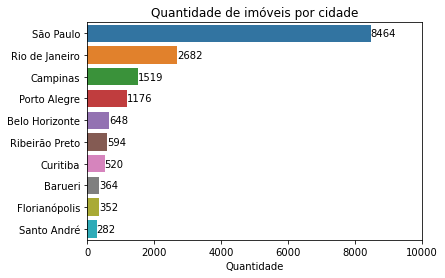

In [177]:
cid_cont = df_imovel['cidade'].value_counts().head(10)

ax = sns.barplot(y=cid_cont.index,x=cid_cont.values)
ax.bar_label(ax.containers[0])
ax.set(title='Quantidade de imóveis por cidade',
      xlabel='Quantidade')
plt.xlim([0,10000])
plt.show()

### Quais os tipos de imóvel?

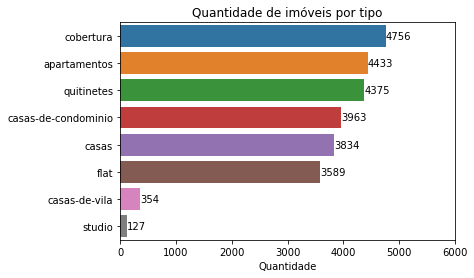

In [178]:
tip_imov_cont = df_imovel['tipo_imovel'].value_counts().head(10)

ax = sns.barplot(y=tip_imov_cont.index,x=tip_imov_cont.values)
ax.bar_label(ax.containers[0])
ax.set(title='Quantidade de imóveis por tipo',
      xlabel='Quantidade')
plt.xlim([0,6000])
plt.show()

### Quais os bairros de São Paulo com mais apartamentos para alugar?

In [179]:
df_imovel['tipo_imovel'].value_counts()

cobertura              4756
apartamentos           4433
quitinetes             4375
casas-de-condominio    3963
casas                  3834
flat                   3589
casas-de-vila           354
studio                  127
Name: tipo_imovel, dtype: int64

In [193]:
df_apt_sp = df_imovel[(df_imovel['cidade']=='São Paulo')&
                      (df_imovel['tipo_imovel'].isin(['apartamentos','quitinetes']))&
                     (df_imovel['tipo_negocio_contexto']=='RENTAL')].copy()

In [194]:
df_apt_sp.shape

(1753, 78)

In [195]:
df_apt_sp['tipo_imovel'].value_counts()

apartamentos    1141
quitinetes       612
Name: tipo_imovel, dtype: int64

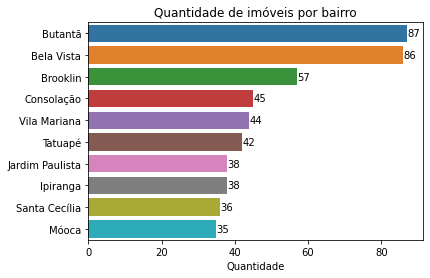

In [196]:

bairro_cont = df_apt_sp['bairro'].value_counts().head(10)

ax = sns.barplot(y=bairro_cont.index,x=bairro_cont.values)
ax.bar_label(ax.containers[0])
ax.set(title='Quantidade de imóveis por bairro',
      xlabel='Quantidade')
plt.show()

### Quais os bairros onde os apartamentos são mais caros em São Paulo?

In [197]:
df_apt_sp['metro_quadrado'] = (df_apt_sp['valor_aluguel']/df_apt_sp['area_total']).round(2)
df_apt_sp.head(3)

,numero_licenca,nome_corretora,tipo_imovel,aceita_troca,cidade,confiabilidade,pais,nivel,bairro,latitude,longitude,fonte,precisao,estado,rua,numero_rua,cep,zona,id_anunciante,comodidades,quintal,churrasqueira,banheiros,banheira,quartos,tipo_negocio_contexto,data_criacao,descricao,exibir_tipo_endereco,id_externo,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,id,inativo,id_legado,link,tipo_anuncio,vista_montanha,vagas_garagem,salao_festas,playground,piscina,portal,preview,etiqueta_negocio,tipo_negocio,alugado,venda,condominio,periodo,valor,valor_aluguel,valor_total_aluguel,valor_venda,iptu_ano,tipo_propriedade,tipo_publicacao,sauna,antiruido,quadra,subtitulo,suites,quadra_tenis,titulo,area_total,andar_unitario,subtipos_unidade,tipos_unidade,unidades_andar,data_atualizacao,area_util,tipo_uso,tipo,metro_quadrado
0,04268-J-SP,ADI Assessoria e Imóveis Ltda,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Parada Inglesa,-23493796.0,-46605705.0,GOOGLE,GEOMETRIC_CENTER,São Paulo,Rua Manajeru,NaN,NaN,Zona Norte,7bf57a4f-0a40-781d-c7b0-5af8f92bd22d,NaN,False,False,1.0,False,2,RENTAL,2020-06-17T10:12:05.109Z,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,ALL,2481,False,NaN,False,False,False,False,False,2486576702,False,NaN,/imovel/aluguel-apartamento-2-quartos-parada-i...,USED,False,NaN,False,False,False,ZAP,False,Alugar,RENTAL,True,False,50.0,mês,1300.0,1300.0,1350.0,NaN,50.0,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,NaN,False,SãO PAULO - Apartamento Padrão - Parada Inglesa,45.0,0,NaN,APARTMENT,0,2020-07-24T05:06:08.843Z,45.0,RESIDENTIAL,superPremium,28.89
4,24344-J-SP,QUINTO ANDAR SERVICOS IMOBILIARIOS LTDA,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Ipiranga,-23598672.0,-46604629.0,GOOGLE,ROOFTOP,São Paulo,Rua Clemente Pereira,64,4216060.0,Zona Sul,a8c36aa5-da1c-0c25-7d28-b5e62fed6a80,BARBECUE_GRILL|POOL|ELEVATOR|PLAYGROUND|SPORTS...,False,True,3.0,False,2,RENTAL,2020-07-28T22:32:55.573Z,"Alugue rápido, sem fiador e com segurança! Age...",ALL,893111543,False,NaN,False,False,False,False,False,2490870778,False,NaN,/imovel/aluguel-apartamento-2-quartos-com-pisc...,USED,False,2.0,True,True,True,ZAP,False,Alugar,RENTAL,True,False,536.0,mês,2600.0,2600.0,3136.0,NaN,17.0,UNIT,PREMIUM,True,False,True,Apartamento para alugar em,2.0,False,São Paulo - Apartamento Padrão - Ipiranga,69.0,0,NaN,APARTMENT,0,2020-07-29T04:32:26.854Z,69.0,RESIDENTIAL,premium,37.68
6,24344-J-SP,QUINTO ANDAR SERVICOS IMOBILIARIOS LTDA,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Brooklin,-23613943.0,-46690936.0,GOOGLE,ROOFTOP,São Paulo,Rua Castilho,155,4568010.0,Zona Sul,a8c36aa5-da1c-0c25-7d28-b5e62fed6a80,BARBECUE_GRILL|POOL|ELEVATOR|FURNISHED|LAUNDRY...,False,True,2.0,False,1,RENTAL,2020-07-25T09:43:32.289Z,"Alugue rápido, sem fiador e com segurança! Age...",ALL,893098583,False,NaN,True,False,False,False,False,2490569281,False,NaN,/imovel/aluguel-apartamento-1-quarto-mobiliado...,USED,False,1.0,True,False,True,ZAP,False,Alugar,RENTAL,True,False,880.0,mês,4900.0,4900.0,5780.0,NaN,109.0,UNIT,PREMIUM,True,False,False,Apartamento para alugar em,1.0,False,São Paulo - Apartamento Padrão - Brooklin,67.0,0,NaN,APARTMENT,0,2020-07-25T21:53:34.120Z,67.0,RESIDENTIAL,premium,73.13


In [198]:
gr_bairro = df_apt_sp.groupby(['bairro','zona'],as_index=False).agg(
    qt_imoveis = ('valor_aluguel', pd.Series.count), avg_aluguel =('valor_aluguel',np.mean),
    median_aluguel =('valor_aluguel',np.median), avg_metro_quadrado =('metro_quadrado',np.mean),
    median_metro_quadrado =('metro_quadrado',np.median),
    ).round(2)
gr_bairro[gr_bairro['qt_imoveis']>=15].sort_values(by='median_metro_quadrado',ascending=False, ignore_index=True).head(10)

,bairro,zona,qt_imoveis,avg_aluguel,median_aluguel,avg_metro_quadrado,median_metro_quadrado
0,Itaim Bibi,Zona Sul,25,6281.64,5000.0,83.50,85.42
1,Vila Olímpia,Zona Sul,31,4283.16,3815.0,77.61,77.43
2,Pinheiros,Zona Oeste,35,3545.97,3500.0,70.45,75.00
3,Jardim Paulista,Zona Sul,38,4817.63,4425.0,72.35,72.34
4,Butantã,Zona Oeste,87,273156.90,1330.0,16505.54,69.04
5,Brooklin,Zona Sul,57,4214.12,3500.0,63.97,68.06
6,Vila Madalena,Zona Oeste,17,3750.00,3500.0,63.85,67.86
7,Cerqueira César,Centro,15,3473.33,2900.0,70.62,63.33
8,Campo Belo,Zona Sul,21,4018.76,3000.0,64.54,60.11
9,Moema,Zona Sul,21,5940.95,4800.0,60.80,57.14


In [199]:
gr_bairro[gr_bairro['qt_imoveis']>=15].sort_values(by='median_metro_quadrado',ascending=False, ignore_index=True).tail(10)

,bairro,zona,qt_imoveis,avg_aluguel,median_aluguel,avg_metro_quadrado,median_metro_quadrado
23,Vila Leopoldina,Zona Oeste,32,78071.56,3400.0,5385.94,37.61
24,Ipiranga,Zona Sul,38,158222.39,1900.0,6692.64,36.23
25,Aclimação,Centro,23,82310.87,1800.0,2237.28,36.00
26,Móoca,Zona Leste,35,54729.89,1700.0,97.85,31.48
27,Cambuci,Zona Sul,20,101074.40,1600.0,2872.01,31.00
28,Panamby,Zona Sul,16,2595.00,2250.0,31.03,30.90
29,Tatuapé,Zona Leste,42,22105.33,2200.0,30.63,28.33
30,Morumbi,Zona Sul,19,2449.32,2000.0,28.90,25.75
31,Santana,Zona Norte,20,2045.00,1850.0,27.15,25.46
32,Jardim Marajoara,Zona Sul,18,3145.56,2250.0,27.40,24.72


### Análise pró-modelagem

__Identificação de outliers__

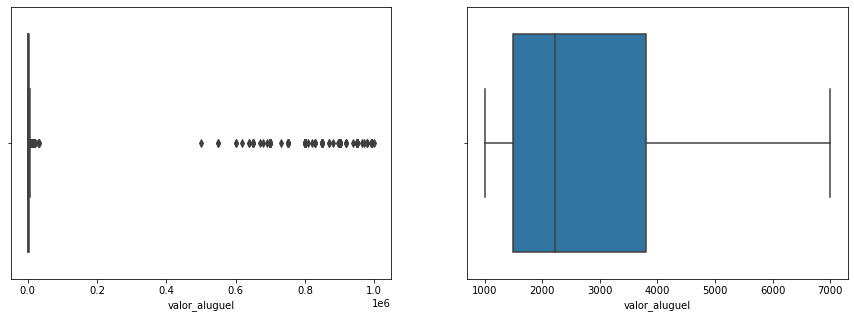

In [641]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_apt_sp,x='valor_aluguel',ax=ax[0])
sns.boxplot(data=df_apt_sp,x='valor_aluguel',ax=ax[1],showfliers=False)
plt.show()

## Pré-processamento

- Separação em treino e teste
- Remoção de outliers no faturamento de cliente
- Busca por variáveis super-correlacionadas
- Seleção de variáveis utilizando método de embaralhamento.

__Variáveis para modelagem__

In [322]:
df_apt_sp['apartamentos'] = 1*(df_apt_sp['tipo_imovel']=='apartamentos')

In [490]:
features = ['apartamentos', 'latitude','longitude', 'quintal', 'churrasqueira',
 'banheiros', 'banheira', 'quartos', 'lareira', 'andares', 'mobiliado', 'jardim',
 'salao_convidados', 'academia', 'jacuzzi', 'inativo', 'vista_montanha', 'vagas_garagem',
 'salao_festas', 'playground', 'piscina', 'condominio', 'iptu_ano', 'sauna', 'antiruido',
 'quadra', 'suites', 'quadra_tenis', 'area_total', 'andar_unitario','area_util']

target = 'valor_aluguel'

### Separação em treino e teste

In [491]:
df_out = df_apt_sp[df_apt_sp[target]<=10000]
df_out.head(2)

,numero_licenca,nome_corretora,tipo_imovel,aceita_troca,cidade,confiabilidade,pais,nivel,bairro,latitude,longitude,fonte,precisao,estado,rua,numero_rua,cep,zona,id_anunciante,comodidades,quintal,churrasqueira,banheiros,banheira,quartos,tipo_negocio_contexto,data_criacao,descricao,exibir_tipo_endereco,id_externo,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,id,inativo,id_legado,link,tipo_anuncio,vista_montanha,vagas_garagem,salao_festas,playground,piscina,portal,preview,etiqueta_negocio,tipo_negocio,alugado,venda,condominio,periodo,valor,valor_aluguel,valor_total_aluguel,valor_venda,iptu_ano,tipo_propriedade,tipo_publicacao,sauna,antiruido,quadra,subtitulo,suites,quadra_tenis,titulo,area_total,andar_unitario,subtipos_unidade,tipos_unidade,unidades_andar,data_atualizacao,area_util,tipo_uso,tipo,metro_quadrado,apartamentos
0,04268-J-SP,ADI Assessoria e Imóveis Ltda,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Parada Inglesa,-23493796.0,-46605705.0,GOOGLE,GEOMETRIC_CENTER,São Paulo,Rua Manajeru,NaN,NaN,Zona Norte,7bf57a4f-0a40-781d-c7b0-5af8f92bd22d,NaN,False,False,1.0,False,2,RENTAL,2020-06-17T10:12:05.109Z,LINDO APARTAMENTO PARADA INGLESA<br><br>2 DORM...,ALL,2481,False,NaN,False,False,False,False,False,2486576702,False,NaN,/imovel/aluguel-apartamento-2-quartos-parada-i...,USED,False,NaN,False,False,False,ZAP,False,Alugar,RENTAL,True,False,50.0,mês,1300.0,1300.0,1350.0,NaN,50.0,UNIT,SUPER_PREMIUM,False,False,False,Apartamento para alugar em,NaN,False,SãO PAULO - Apartamento Padrão - Parada Inglesa,45.0,0,NaN,APARTMENT,0,2020-07-24T05:06:08.843Z,45.0,RESIDENTIAL,superPremium,28.89,1
4,24344-J-SP,QUINTO ANDAR SERVICOS IMOBILIARIOS LTDA,apartamentos,False,São Paulo,VALID_STREET,BR,STREET,Ipiranga,-23598672.0,-46604629.0,GOOGLE,ROOFTOP,São Paulo,Rua Clemente Pereira,64,4216060.0,Zona Sul,a8c36aa5-da1c-0c25-7d28-b5e62fed6a80,BARBECUE_GRILL|POOL|ELEVATOR|PLAYGROUND|SPORTS...,False,True,3.0,False,2,RENTAL,2020-07-28T22:32:55.573Z,"Alugue rápido, sem fiador e com segurança! Age...",ALL,893111543,False,NaN,False,False,False,False,False,2490870778,False,NaN,/imovel/aluguel-apartamento-2-quartos-com-pisc...,USED,False,2.0,True,True,True,ZAP,False,Alugar,RENTAL,True,False,536.0,mês,2600.0,2600.0,3136.0,NaN,17.0,UNIT,PREMIUM,True,False,True,Apartamento para alugar em,2.0,False,São Paulo - Apartamento Padrão - Ipiranga,69.0,0,NaN,APARTMENT,0,2020-07-29T04:32:26.854Z,69.0,RESIDENTIAL,premium,37.68,1


In [493]:
df_out.shape

(1556, 80)

In [494]:
df_apt_sp.shape

(1753, 80)

In [496]:
df_apt_sp[target].max()

999000.0

In [497]:
df_out[target].max()

10000.0

In [498]:
X = df_out[features]*1
y = df_out[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [499]:
X_train.head()

,apartamentos,latitude,longitude,quintal,churrasqueira,banheiros,banheira,quartos,lareira,andares,mobiliado,jardim,salao_convidados,academia,jacuzzi,inativo,vista_montanha,vagas_garagem,salao_festas,playground,piscina,condominio,iptu_ano,sauna,antiruido,quadra,suites,quadra_tenis,area_total,andar_unitario,area_util
961,1,-23599325.0,-46674272.0,0,0,1.0,0,1,0,NaN,0,0,0,0,0,0,0,1.0,0,0,0,NaN,NaN,0,0,0,NaN,0,32.0,0,32.0
1296,1,-23565404.0,-46584224.0,0,1,2.0,0,2,0,NaN,0,0,0,0,0,0,0,2.0,0,0,1,685.0,207.0,0,0,0,1.0,0,86.0,0,86.0
3901,1,-23499632.0,-46700168.0,0,1,1.0,0,2,0,NaN,0,0,0,0,0,0,0,1.0,1,1,1,600.0,5.0,0,0,1,0.0,0,58.0,0,58.0
931,1,-23519157.0,-46680445.0,0,0,2.0,0,2,0,NaN,0,0,0,0,0,0,0,1.0,0,0,0,1036.0,212.0,0,0,0,1.0,0,83.0,0,83.0
2965,1,-23541085.0,-4667096.0,0,0,2.0,0,2,0,NaN,0,0,0,0,0,0,0,1.0,1,0,0,1600.0,337.0,0,0,0,0.0,0,123.0,0,123.0


In [500]:
X_train.isna().sum().sort_values(ascending=False).head(10)

andares           1149
iptu_ano           403
suites             305
condominio         172
vagas_garagem      158
area_total          46
apartamentos         0
vista_montanha       0
andar_unitario       0
quadra_tenis         0
dtype: int64

Andares - remover\
area_total - remover e ficar com área útil
iptu_ano - substituir pela média\
condomínio - agrupar similares e substituir pela média do grupo\
suítes - substituir por zero\
vagas_garagem - substituir por 0\

Andares - remover

In [501]:
X_train.drop('andares',axis=1,inplace=True)
X_test.drop('andares',axis=1,inplace=True)

X_train.drop('area_total',axis=1,inplace=True)
X_test.drop('area_total',axis=1,inplace=True)

iptu_ano - substituir pela média\
condomínio - agrupar similares e substituir pela média do grupo\

In [502]:
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

X_train['bins_area_util'] = kbins.fit_transform(X_train['area_util'].values.reshape(-1,1)).round(2)
X_test['bins_area_util'] = kbins.transform(X_test['area_util'].values.reshape(-1,1)).round(2)

In [503]:
gr_nan = X_train.groupby('bins_area_util',as_index=False)['iptu_ano','condominio'].mean()
gr_nan

,bins_area_util,iptu_ano,condominio
0,0.0,164.392157,456.767089
1,1.0,296.601173,624.096567
2,2.0,668.076923,934.853846
3,3.0,509.097561,1280.454545
4,4.0,738.125000,1747.611111
5,5.0,1019.400000,2539.200000
6,6.0,783.400000,2882.500000
7,7.0,1000.000000,1700.000000
8,8.0,1915.666667,3664.666667
9,9.0,1646.000000,3862.000000


In [504]:
X_train.loc[X_train['iptu_ano'].isna(),'iptu_ano'] = X_train.loc[X_train['iptu_ano'].isna(),'bins_area_util'
           ].replace(dict(gr_nan[['bins_area_util','iptu_ano']].values.round(2)))

X_test.loc[X_test['iptu_ano'].isna(),'iptu_ano'] = X_test.loc[X_test['iptu_ano'].isna(),'bins_area_util'
           ].replace(dict(gr_nan[['bins_area_util','iptu_ano']].values.round(2)))

In [505]:
X_train.loc[X_train['condominio'].isna(),'condominio'] = X_train.loc[X_train['condominio'].isna(),'bins_area_util'
           ].replace(dict(gr_nan[['bins_area_util','condominio']].values.round(2)))

X_test.loc[X_test['condominio'].isna(),'condominio'] = X_test.loc[X_test['condominio'].isna(),'bins_area_util'
           ].replace(dict(gr_nan[['bins_area_util','condominio']].values.round(2)))

In [506]:
X_train.drop('bins_area_util',axis=1,inplace=True)
X_test.drop('bins_area_util',axis=1,inplace=True)

suítes - substituir por zero

In [507]:
X_train['suites'] = X_train['suites'].fillna(0)
X_test['suites'] = X_test['suites'].fillna(0)

In [508]:
X_train['vagas_garagem'] = X_train['vagas_garagem'].fillna(0)
X_test['vagas_garagem'] = X_test['vagas_garagem'].fillna(0)

In [509]:
X_train.isna().sum().sum()

0

In [510]:
X_test.isna().sum().sum()

0

In [511]:
X_train.head()

,apartamentos,latitude,longitude,quintal,churrasqueira,banheiros,banheira,quartos,lareira,mobiliado,jardim,salao_convidados,academia,jacuzzi,inativo,vista_montanha,vagas_garagem,salao_festas,playground,piscina,condominio,iptu_ano,sauna,antiruido,quadra,suites,quadra_tenis,andar_unitario,area_util
961,1,-23599325.0,-46674272.0,0,0,1.0,0,1,0,0,0,0,0,0,0,0,1.0,0,0,0,456.77,164.39,0,0,0,0.0,0,0,32.0
1296,1,-23565404.0,-46584224.0,0,1,2.0,0,2,0,0,0,0,0,0,0,0,2.0,0,0,1,685.00,207.00,0,0,0,1.0,0,0,86.0
3901,1,-23499632.0,-46700168.0,0,1,1.0,0,2,0,0,0,0,0,0,0,0,1.0,1,1,1,600.00,5.00,0,0,1,0.0,0,0,58.0
931,1,-23519157.0,-46680445.0,0,0,2.0,0,2,0,0,0,0,0,0,0,0,1.0,0,0,0,1036.00,212.00,0,0,0,1.0,0,0,83.0
2965,1,-23541085.0,-4667096.0,0,0,2.0,0,2,0,0,0,0,0,0,0,0,1.0,1,0,0,1600.00,337.00,0,0,0,0.0,0,0,123.0


__Drop constant__

In [512]:
constant_selector = DropConstantFeatures(tol=0.9)

X_train_const = constant_selector.fit_transform(X_train)
X_test_const = constant_selector.transform(X_test)

In [513]:
[x for x in X_train.columns if x not in X_train_const.columns]

['quintal',
 'banheira',
 'lareira',
 'jardim',
 'salao_convidados',
 'jacuzzi',
 'inativo',
 'vista_montanha',
 'antiruido',
 'quadra_tenis',
 'andar_unitario']

__Outlier__

In [514]:
outlier = Winsorizer()
X_train_out = outlier.fit_transform(X_train_const)
X_train_out.head()

,apartamentos,latitude,longitude,churrasqueira,banheiros,quartos,mobiliado,academia,vagas_garagem,salao_festas,playground,piscina,condominio,iptu_ano,sauna,quadra,suites,area_util
961,1,-23599325.0,-4.667427e+07,0,1.0,1.0,0,0,1.0,0,0,0,456.77,164.39,0,0,0.0,32.0
1296,1,-23565404.0,-4.658422e+07,1,2.0,2.0,0,0,2.0,0,0,1,685.00,207.00,0,0,1.0,86.0
3901,1,-23499632.0,-4.670017e+07,1,1.0,2.0,0,0,1.0,1,1,1,600.00,5.00,0,1,0.0,58.0
931,1,-23519157.0,-4.668044e+07,0,2.0,2.0,0,0,1.0,0,0,0,1036.00,212.00,0,0,1.0,83.0
2965,1,-23541085.0,-4.883720e+06,0,2.0,2.0,0,0,1.0,1,0,0,1600.00,337.00,0,0,0.0,123.0


In [515]:
X_test_out = outlier.transform(X_test_const)
X_test_out.head()

,apartamentos,latitude,longitude,churrasqueira,banheiros,quartos,mobiliado,academia,vagas_garagem,salao_festas,playground,piscina,condominio,iptu_ano,sauna,quadra,suites,area_util
1396,1,-23576063.0,-46619356.0,1,2.0,2,0,0,2.0,1,1,1,900.0,74.0,0,1,1.0,68.0
26683,0,-23548366.0,-46645164.0,0,1.0,1,0,0,0.0,0,0,0,389.0,30.0,0,0,0.0,35.0
3016,1,-23558157.0,-46628147.0,0,3.0,3,1,0,0.0,0,0,0,281.0,296.6,0,0,2.0,55.0
2641,1,-23566304.0,-46663203.0,0,2.0,2,1,0,1.0,1,0,0,1100.0,100.0,0,0,2.0,95.0
1877,1,-23546278.0,-46694569.0,0,2.0,3,1,0,2.0,1,1,1,1100.0,337.0,1,1,1.0,84.0


__Drop correlated__

In [516]:
drop_selector = DropCorrelatedFeatures(threshold=0.9)
X_train_drop = drop_selector.fit_transform(X_train_out)
X_test_drop = drop_selector.fit_transform(X_test_out)

In [517]:
[x for x in X_train_out.columns if x not in X_train_drop.columns]

[]

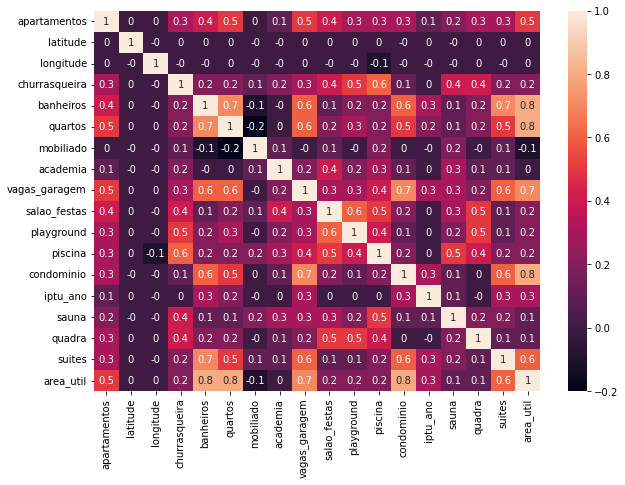

In [518]:
plt.figure(figsize=(10,7))
sns.heatmap(X_train_drop.corr().round(1),annot=True)
plt.show()

__Select by shuffling__

In [519]:
lgbm = LGBMRegressor(random_state=0)
lgbm.fit(X_train_drop,y_train)

selector = SelectByShuffling(lgbm,random_state=0,cv=5,scoring='neg_mean_squared_error')
selector = selector.fit(X_train_drop,y_train)

In [520]:
to_drop = selector.features_to_drop_
final_features = X_train_drop.drop(to_drop,axis=1).columns.tolist()
final_features

['latitude', 'longitude', 'condominio', 'iptu_ano', 'area_util']

## Modelos

### Linear regression

In [521]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [522]:
lr_model = LinearRegression()
scores = cross_val_score(lr_model, X_train_drop, y_train, cv=5,scoring='neg_mean_squared_error')
print('O erro médio quadrático é de:', round(np.sqrt(-scores).mean(),2),'+-',round(np.sqrt(-scores).std(),2))

O erro médio quadrático é de: 1023.66 +- 119.78


### Decision Tree

In [523]:
tree_model = DecisionTreeRegressor()
scores = cross_val_score(tree_model, X_train_drop, y_train, cv=5,scoring='neg_mean_squared_error')
print('O erro médio quadrático é de:', round(np.sqrt(-scores).mean(),2),'+-',round(np.sqrt(-scores).std(),2))

O erro médio quadrático é de: 1208.54 +- 125.99


### SVM

In [524]:
svm_model = SVR()
scores = cross_val_score(svm_model, X_train_drop, y_train, cv=5,scoring='neg_mean_squared_error')
print('O erro médio quadrático é de:', round(np.sqrt(-scores).mean(),2),'+-',round(np.sqrt(-scores).std(),2))

O erro médio quadrático é de: 1630.84 +- 143.59


### Random Forest

In [547]:
%%time
rf_model = RandomForestRegressor()
scores = cross_val_score(rf_model, X_train_drop, y_train, cv=5,scoring='neg_mean_squared_error')
print('O erro médio quadrático é de:', round(np.sqrt(-scores).mean(),2),'+-',round(np.sqrt(-scores).std(),2))

O erro médio quadrático é de: 921.53 +- 115.52
CPU times: total: 2.22 s
Wall time: 2.24 s


### LightGBM

In [546]:
%%time
lgbm_model = LGBMRegressor()
scores = cross_val_score(lgbm_model, X_train_drop, y_train, cv=5,scoring='neg_mean_squared_error')
print('O erro médio quadrático é de:', round(np.sqrt(-scores).mean(),2),'+-',round(np.sqrt(-scores).std(),2))

O erro médio quadrático é de: 933.1 +- 113.97
CPU times: total: 4.42 s
Wall time: 604 ms


## Optimização

In [590]:
def objective(trial):
        
    model = RandomForestRegressor(
            n_estimators = trial.suggest_int("n_estimators", 30, 100),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            n_jobs=-1,
            random_state=0,
            ccp_alpha=trial.suggest_float("ccp_alpha", 0, 1)
        )
    
    score = cross_val_score(model, X_train_drop, y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

    metric = np.sqrt(-score).mean()
    
    return metric

In [591]:
#definir a seed para obter resultados reprodutíveis
sampler = RandomSampler(seed=10)

#Função 'estudo' que maximiza ou minimiza a função objetivo
study = optuna.create_study(
    direction="minimize",study_name='rf_optmization', sampler=sampler
)

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=1000,show_progress_bar=True);

  0%|          | 0/1000 [00:00<?, ?it/s]

In [592]:
study.best_value

920.1644395494441

In [593]:
#melhores parâmetros
study.best_params

{'n_estimators': 57, 'min_samples_leaf': 1, 'ccp_alpha': 0.29116373677210794}

In [594]:
results = study.trials_dataframe()
results.sort_values(by='value',ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_ccp_alpha,params_min_samples_leaf,params_n_estimators,state
380,380,989.020231,2022-11-18 10:15:27.602089,2022-11-18 10:15:27.841084,0 days 00:00:00.238995,0.650114,10,43,COMPLETE
188,188,988.919257,2022-11-18 10:14:06.876305,2022-11-18 10:14:07.089690,0 days 00:00:00.213385,0.302930,10,39,COMPLETE
907,907,988.438952,2022-11-18 10:19:03.633766,2022-11-18 10:19:03.859386,0 days 00:00:00.225620,0.444013,10,40,COMPLETE
914,914,988.438726,2022-11-18 10:19:06.748896,2022-11-18 10:19:06.966911,0 days 00:00:00.218015,0.254288,10,40,COMPLETE
200,200,987.967030,2022-11-18 10:14:11.209622,2022-11-18 10:14:11.418491,0 days 00:00:00.208869,0.717340,10,41,COMPLETE


Em seguida criamos o modelo com os parâmetros de optimização.

In [595]:
opt_model = RandomForestRegressor(**study.best_params)
opt_model.fit(X_train_drop, y_train)

RandomForestRegressor(ccp_alpha=0.29116373677210794, n_estimators=57)

### Métricas

In [598]:
y_pred_train = opt_model.predict(X_train_drop)
y_pred_test = opt_model.predict(X_test_drop)

__Base de treino__

In [610]:
df_res_train = pd.DataFrame(y_train.values,columns=['aluguel_real'])
df_res_train['aluguel_predito'] = y_pred_train.round(2)
df_res_train['erro'] = df_res_train['aluguel_real']-df_res_train['aluguel_predito']
df_res_train.head()

,aluguel_real,aluguel_predito,erro
0,4000.0,3513.68,486.32
1,3100.0,2822.16,277.84
2,1460.0,1615.46,-155.46
3,4300.0,3755.54,544.46
4,5000.0,4481.86,518.14


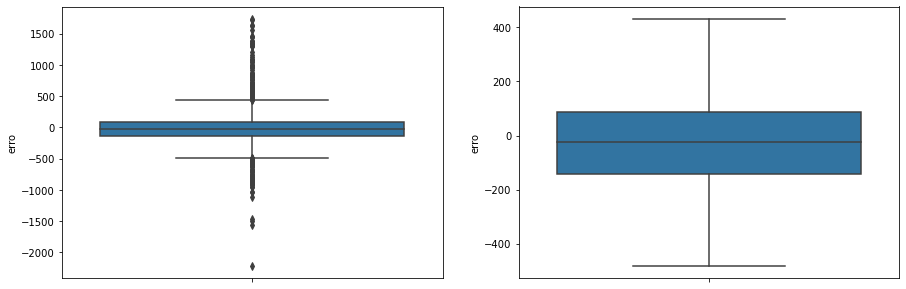

In [618]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_res_train,y='erro',showfliers=True,ax=ax[0])
sns.boxplot(data=df_res_train,y='erro',showfliers=False,ax=ax[1])
plt.show()

In [634]:
df_metric_train = df_res_train[np.abs(df_res_train['erro'])<500]
print('A raiz do erro médio quadrático na base de treino é de:',mean_squared_error(df_res_train['aluguel_real'],df_res_train['aluguel_predito'],squared=False).round(2))
print('A raiz do erro médio quadrático na base de treino, desconsiderando outliers de erro, é de:',mean_squared_error(df_metric_train['aluguel_real'],df_metric_train['aluguel_predito'],squared=False).round(2))

A raiz do erro médio quadrático na base de treino é de: 343.49
A raiz do erro médio quadrático na base de treino, desconsiderando outliers de erro, é de: 184.31


In [635]:
print('O erro médio absoluto na base de treino é de:',mean_absolute_error(df_res_train['aluguel_real'],df_res_train['aluguel_predito']).round(2))
print('O erro médio absoluto na base de treino, desconsiderando outliers de erro, é de:',mean_absolute_error(df_metric_train['aluguel_real'],df_metric_train['aluguel_predito']).round(2))

O erro médio absoluto na base de treino é de: 213.59
O erro médio absoluto na base de treino, desconsiderando outliers de erro, é de: 139.09


__Base de teste__

In [632]:
df_res_test = pd.DataFrame(y_test.values,columns=['aluguel_real'])
df_res_test['aluguel_predito'] = y_pred_test.round(2)
df_res_test['erro'] = df_res_test['aluguel_real']-df_res_test['aluguel_predito']
df_res_test.head()

,aluguel_real,aluguel_predito,erro
0,3320.0,2353.59,966.41
1,1300.0,1449.18,-149.18
2,3500.0,2150.85,1349.15
3,4300.0,4339.37,-39.37
4,3700.0,5110.49,-1410.49


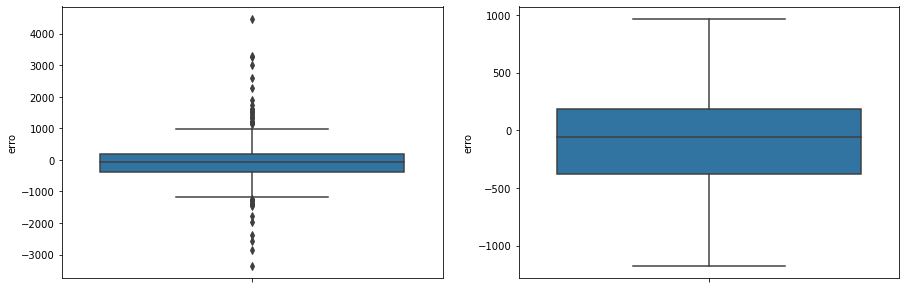

In [633]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_res_test,y='erro',showfliers=True,ax=ax[0])
sns.boxplot(data=df_res_test,y='erro',showfliers=False,ax=ax[1])
plt.show()

In [636]:
df_metric_test = df_res_test[np.abs(df_res_test['erro'])<1000]
print('A raiz do erro médio quadrático na base de treino é de:',mean_squared_error(df_res_test['aluguel_real'],df_res_test['aluguel_predito'],squared=False).round(2))
print('A raiz do erro médio quadrático na base de treino, desconsiderando outliers de erro, é de:',mean_squared_error(df_metric_test['aluguel_real'],df_metric_test['aluguel_predito'],squared=False).round(2))

A raiz do erro médio quadrático na base de treino é de: 815.7
A raiz do erro médio quadrático na base de treino, desconsiderando outliers de erro, é de: 398.02


In [645]:
print('O erro médio absoluto na base de treino é de:',mean_absolute_error(df_res_test['aluguel_real'],df_res_test['aluguel_predito']).round(2))
print('O erro médio absoluto na base de treino, desconsiderando outliers de erro, é de:',mean_absolute_error(df_metric_test['aluguel_real'],df_metric_test['aluguel_predito']).round(2))

O erro médio absoluto na base de treino é de: 515.35
O erro médio absoluto na base de treino, desconsiderando outliers de erro, é de: 299.0


__Explicabilidade__

 99%|===================| 1236/1244 [00:59<00:00]        

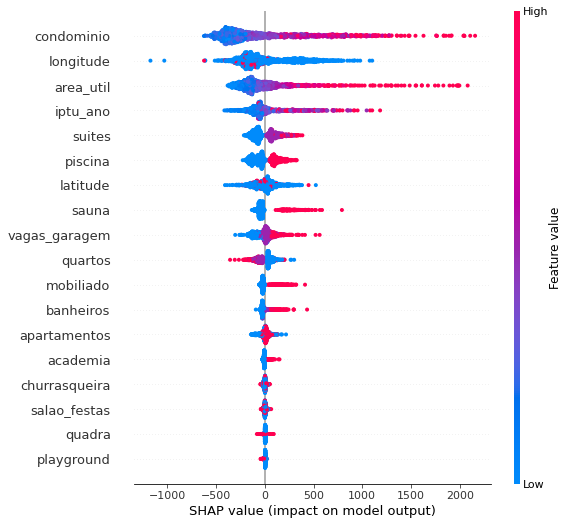

In [644]:
explainer = shap.Explainer(opt_model,X_train_drop,feature_names=X_train_drop.columns)
shap_values = explainer(X_train_drop)
shap.plots.beeswarm(shap_values, max_display=50)